<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/8d_GRU_SentimentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimientos con GRU

In [1]:
# establecer parametros para almacenar y cargar el conjunto de datos del repositorio de Github
import os

URL = 'https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv'
data_folder = 'data'
filepath = os.path.join(data_folder, 'text_emotion.csv')
print (f"filepath:\t{filepath}")

filepath:	data/text_emotion.csv


## Cargar el conjunto de datos

In [2]:
# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

--2022-03-10 15:47:04--  https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4394791 (4.2M) [text/plain]
Saving to: ‘data/text_emotion.csv’

data/text_emotion.c 100%[===================>]   4.19M  --.-KB/s    in 0.1s    

2022-03-10 15:47:04 (31.6 MB/s) - ‘data/text_emotion.csv’ saved [4394791/4394791]



In [3]:
# comprobrar
! ls -lh data/*

-rw-r--r-- 1 root root 4.2M Mar 10 15:47 data/text_emotion.csv


## Analizar conjunto de datos

In [4]:
import pandas as pd

df = pd.read_csv('data/text_emotion.csv')

# eliminar columnas 'tweet_id' y 'author'
df.drop('tweet_id',axis=1,inplace=True)
df.drop('author',axis=1,inplace=True)
print (df.head(10))
print (f"Longitud de tweets: {len(df):,}")

    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...
5       worry  Re-pinging @ghostridah14: why didn't you go to...
6     sadness  I should be sleep, but im not! thinking about ...
7       worry               Hmmm. http://www.djhero.com/ is down
8     sadness            @charviray Charlene my love. I miss you
9     sadness         @kelcouch I'm sorry  at least it's Friday?
Longitud de tweets: 40,000


1	8638	neutral
2	8459	worry
3	5209	happiness
4	5165	sadness
5	3842	love
6	2187	surprise
7	1776	fun
8	1526	relief
9	1323	hate
10	827	empty
11	759	enthusiasm
12	179	boredom
13	110	anger

40,000 tweets


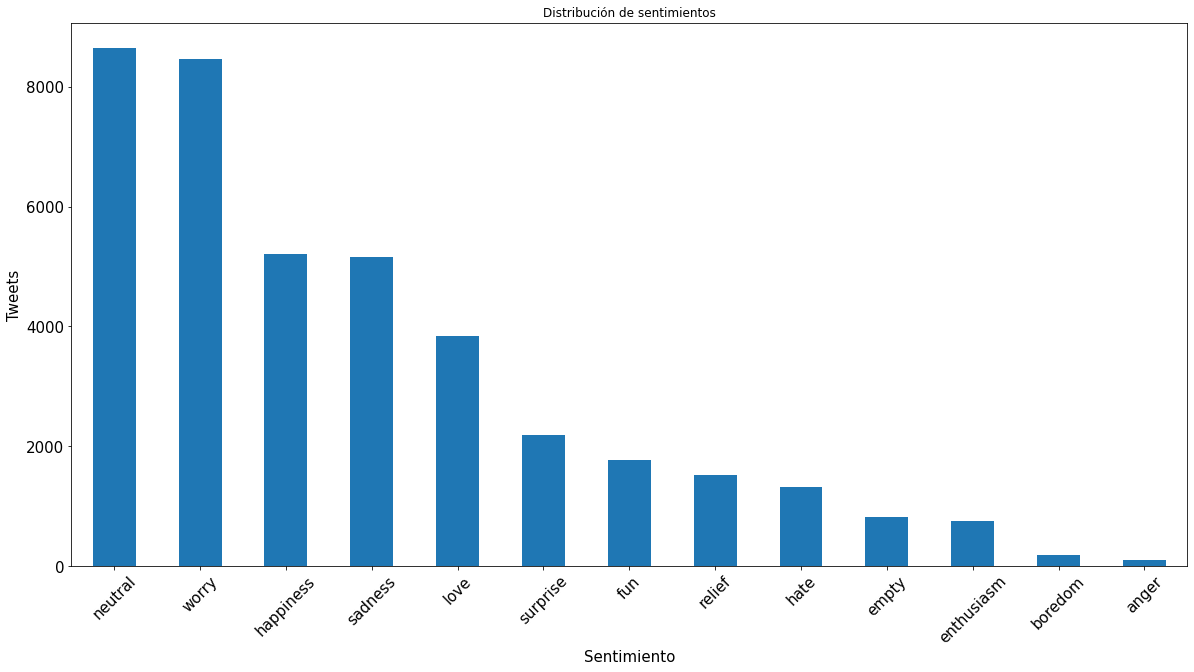

In [5]:
import matplotlib.pyplot as plt

sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(20, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=45, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

## Preprocesamiento de los datos
Realizar el preprocesamiento necesario, que incluye la limpieza y otros elementos como la toeknización y lematización

### Limpieza de los tweets

In [6]:
# preprocesamiento
import numpy as np
def limpiezaDeTweets(tweet):
  import re
  tweet = re.sub(r'RT @\w+: '," ", tweet) # eliminar retweets
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet) # eliminar urls
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # eliminar usuarios
  tweet = tweet.lower() # convertir a minúsculas
  tweet = re.sub(r'[^a-z0-9\'\.,:; ]+', ' ', tweet) # eliminar todos los caracteres que no esten en los definidos
  tweet = ' '.join(tweet.split()) # eliminar múltiples espacios, solo conservar un espacio

  return tweet


df['content'] = df['content'].astype('str')
df['content'] = df['content'].apply(lambda x: limpiezaDeTweets(x))

df.drop_duplicates(keep=False, inplace=True)

df = df.replace(r'^\s*$', np.NaN, regex=True)

df = df.dropna()

print (df.head(10))
print (f"\nTotal:\t{len(df):,}\n")

    sentiment                                            content
0       empty  i know i was listenin to bad habit earlier and...
1     sadness  layin n bed with a headache ughhhh...waitin on...
2     sadness                funeral ceremony...gloomy friday...
3  enthusiasm                wants to hang out with friends soon
4     neutral  we want to trade with someone who has houston ...
5       worry  re pinging : why didn't you go to prom bc my b...
6     sadness  i should be sleep, but im not thinking about a...
7       worry                                      hmmm. is down
8     sadness                       charlene my love. i miss you
9     sadness                     i'm sorry at least it's friday

Total:	39,314



In [7]:
# graficar los tweets limpios por clase
sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

1	8380	neutral
2	8374	worry
3	5126	sadness
4	5099	happiness
5	3695	love
6	2181	surprise
7	1774	fun
8	1514	relief
9	1320	hate
10	805	empty
11	757	enthusiasm
12	179	boredom
13	110	anger

39,314 tweets


## Preparar el conjunto de datos

In [8]:
# obtener vocabulario de clases
from tqdm.auto import tqdm

tag_vocabulary = [sent for sent in sentiments]
tag_vocabulary.sort()

tok_vocabulary = []
# obtener vocabulario de tokens
for index, row in tqdm(df.iterrows(), desc="obteniendo vocabulario de tokens", total=len(df)):
  for token in row['content'].split():
    if token not in tok_vocabulary: tok_vocabulary.append(token)

max_tweet_length = max(len(lst.split()) for lst in df['content'].to_list())
min_tweet_length = min(len(lst.split()) for lst in df['content'].to_list())

print (f'tweet longitud mínima:\t{min_tweet_length}')
print (f'tweet longitud máxima:\t{max_tweet_length}\n')

print (f'longitud vocabulario de clases:\t{len(tag_vocabulary)}')
print (f'longitud vocabulario de tokens:\t{len(tok_vocabulary):,}\n')

# visualizar los 10 tokens más frecuentes
for i, tok in enumerate(tok_vocabulary):
  if i==10: break
  print (f"{i+1}\t{tok}")


obteniendo vocabulario de tokens:   0%|          | 0/39314 [00:00<?, ?it/s]

tweet longitud mínima:	1
tweet longitud máxima:	40

longitud vocabulario de clases:	13
longitud vocabulario de tokens:	46,634

1	i
2	know
3	was
4	listenin
5	to
6	bad
7	habit
8	earlier
9	and
10	started


In [9]:
# construir vocabularios stoi e itos de clases y tokens

tag_stoi = {tok : i for i, tok in enumerate(tag_vocabulary)}
tag_itos = {i : tok for i, tok in enumerate(tag_vocabulary)}

tok_vocabulary.insert(0, '<PAD>')
tok_stoi = {tok : i for i, tok in enumerate(tok_vocabulary)}
tok_itos = {i : tok for i, tok in enumerate(tok_vocabulary)}

print (f"tag_stoi:\t{tag_stoi}")
print (f"tag_itos:\t{tag_itos}\n")

print (f"tok_stoi:\t{len(tok_stoi):,}")
print (f"tok_itos:\t{len(tok_itos):,}")

tag_stoi:	{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}
tag_itos:	{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fun', 5: 'happiness', 6: 'hate', 7: 'love', 8: 'neutral', 9: 'relief', 10: 'sadness', 11: 'surprise', 12: 'worry'}

tok_stoi:	46,635
tok_itos:	46,635


### Transformar tweets a indices y rellenar 

In [10]:
X, Y = [], []
for index, row in tqdm(df.iterrows(), desc="transformando tweets a indices", total=len(df)):
  if len(row['content'].split()) < 40: # rellenar tweets menores a 40 con {'<PAD>': 0}
    tmp_x = [tok_stoi[token] for token in row['content'].split()]
    tmp_x += [tok_stoi['<PAD>']] * (max_tweet_length - len(tmp_x))
    X.append(tmp_x)
  else:
    X.append([tok_stoi[token] for token in row['content'].split()])
  Y.append( tag_stoi[row['sentiment']] )

transformando tweets a indices:   0%|          | 0/39314 [00:00<?, ?it/s]

In [23]:
import numpy as np

Y = np.array(Y, dtype="int32")[:, np.newaxis]
X = np.array(X, dtype="int32")

print (f"Shape Y:\t{Y.shape}")
print (f"\nShape X:\t{X.shape}")

Shape Y:	(39314, 1, 1, 1)

Shape X:	(39314, 40)


### Dividir en conjuntos: Entrenamiento, Validación y Pruebas

In [12]:
# dividir en conjuntos de Train, Val y Test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=1000)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.60, stratify=Y_test, random_state=1000)

print(f"X_train.shape, Y_train.shape: {X_train.shape}, {Y_train.shape}")
print(f"X_val.shape, Y_val.shape: {X_valid.shape}, {Y_valid.shape}")
print(f"X_test.shape, Y_test.shape: {X_test.shape}, {Y_test.shape}")

X_train.shape, Y_train.shape: (27519, 40), (27519, 1)
X_val.shape, Y_val.shape: (7077, 40), (7077, 1)
X_test.shape, Y_test.shape: (4718, 40), (4718, 1)


## Crear conjuntos de datos y cargadores de datos

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# crear los tensores del conjunto de datos
train = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(Y_train, dtype=torch.long))
valid = TensorDataset(torch.tensor(X_valid, dtype=torch.long), torch.tensor(Y_valid, dtype=torch.long))
test = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(Y_test, dtype=torch.long))

batch_size = 256

# crear los cargadores del conjunto de datos
trainloader = DataLoader(train, batch_size=batch_size, drop_last=True, shuffle=True)
validloader = DataLoader(valid, batch_size=batch_size, drop_last=True, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, drop_last=True, shuffle=True)

print (f"{len(trainloader.dataset):,} es la longitud de muestras en trainloader")
print (f"{len(validloader.dataset):,} es la longitud de muestras en validloader")
print (f"{len(testloader.dataset):,} es la longitud de muestras en testloader\n")

print (f"{len(trainloader):,} batches de longitud {batch_size} en trainloader")
print (f"{len(validloader):,} batches de longitud {batch_size} en validloader")
print (f"{len(testloader):,} batches de longitud {batch_size} en testloader")

27,519 es la longitud de muestras en trainloader
7,077 es la longitud de muestras en validloader
4,718 es la longitud de muestras en testloader

107 batches de longitud 256 en trainloader
27 batches de longitud 256 en validloader
18 batches de longitud 256 en testloader


## Definir el modelo

### Bibliotecas a usar

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

### Modelo GRU

In [15]:
class SentimentAnalysis_GRU(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, num_layers, output_size):
        super().__init__()
        self.batch = batch_sz
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size
        
        # definir la capa de embeddings
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        # definir el Dropout
        self.dropout = nn.Dropout(p=0.5)

        # definir capa GRU
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units, num_layers=num_layers)

        # definir capa totalmente conectada (FC)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
        
    def initialize_hidden_state(self):
        # inicializar las unidades ocultas en ceros
        return torch.zeros((num_layers, self.batch, self.hidden_units)) # .to(device) # (num_layers, batch_size, hidden_units)
    
    def forward(self, x):
        # print (f"forward x.shape: {x.shape}") # torch.Size([40, 256] # [longitud_tweet, batch_size]
        x = self.embedding(x) # torch.Size([40, 256, 50] # [longitud_tweet, batch_size, embedding_dim]
        # print (f"forward con embeddings x.shape: {x.shape}") 

        self.hidden = self.initialize_hidden_state() # (device) # torch.Size([1, 256, 100]) # [1, batch_size, hidden_units]
        # print (f"forward initialize self.hidden.shape: {self.hidden.shape}")

        output, self.hidden = self.gru(x, self.hidden) # output = torch.Size([40, 256, 100] # [tweet_length, batch_size, hidden_units], self.hidden = torch.Size([1, 256, 100]) # [1, batch_size, hidden_units]
        # print (f"forward output.shape: {output.shape}")
        # print (f"forward self.hidden.shape: {self.hidden.shape}")
        
        out = output[-1, :, :] # torch.Size([256, 100]) 
        # print (f"forward output[-1, :, :].shape: {output[-1, :, :].shape}")
        
        out = self.dropout(out)

        out = self.fc(out) # torch.Size([40, 256, 100] # [tweet_length, batch_size, hidden_units]
        # print (f"forward fc output: {output.shape}")
        
        return out, self.hidden

In [16]:
# definir funciones para utilizar en el entrenamiento y evaluación
def accuracy(preds, y):
    """Retorna el accuracy por batch"""
    # preds --> [256, 13] ==> debe permutarse así preds.permute(1, 0) --> [13, 256] # 13 clases, 256 batch_size
    # y --> [13]
    max_preds = preds.argmax(dim=1, keepdim=True)  # obtener el índice de la máxima probabilidad # [256, 1] # [batch_size, 1]

    non_pad_elements = (y != tok_stoi['<PAD>']).nonzero()  # preparar enmascaramiento para rellenos # [256, 1]

    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    # correct = (torch.round(torch.sigmoid(preds.permute(1,0))) == y).float() # usar sigmoid para la evaluación
    # correct = (torch.round(F.softmax(preds)) == y).float() # usar softmax para la evaluación
    # correct = [1 for i, j in zip(torch.argmax(y, dim=1), y) if i == j] # elegir el argumento máximo
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    """Obtener el tiempo en minutos y segundos"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
# función del entrenamieto
def train(model, iterator, optimizer, loss_function):
    """
    Entrenar el modelo, recibe el conjunto de datos (iterator), optimizador, y la función de pérdida
    Retorna el loss y el accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    # batch_count = 0
    for x_text, y_label in iterator:
        # x_text --> torch.Size([256, 40]) # [batch_size, tweets_length]
        # y_label --> torch.Size([256, 1]) # [batch_size, label_length]

        # x_text = torch.tensor(x_text, dtype=torch.long)
        # y_label = torch.tensor(y_label, dtype=torch.long)
        
        # restablecer el gradiente
        optimizer.zero_grad()
        
        # obtener las predicciones del batch en proceso
        predictions, _ = model(x_text.permute(1, 0)) # x_text.permute(1, 0) --> torch.Size([40, 256])

        target = y_label.squeeze(1) # torch.Size([256]
        
        # obtener la pérdida
        loss = loss_function(predictions, target)
        # loss = criterion(prediction, target) # este es el mío
        
        # calcular el accuracy
        acc = accuracy(predictions, target)
        
        # Backpropagation
        loss.backward()
        
        # Actualizar (optimizar) los pesos
        optimizer.step()
        
        # Almacenar loss y accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # batch_count += 1
        # print (f"Batch {batch_count}/{len(iterator)} Batch train loss: {loss.item()} Batch train acc: {acc.item()}")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, loss_function):
    """
    Evaluar el conjunto de validación y/o el conjunto de prueba
    Retorna el loss y accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    # indicar la evaluación del modelo
    model.eval()
    
    # batch_count = 0

    # No utilizar cálculos del gradiente
    with torch.no_grad():
    
        for x_text, y_label in iterator:
            # x_text --> torch.Size([256, 40]) # [batch_size, tweets_length]
            # y_label --> torch.Size([256, 1]) # [batch_size, label_length]

            # x_text = torch.tensor(x_text, dtype=torch.long)
            # y_label = torch.tensor(y_label, dtype=torch.long)

            predictions, _ = model(x_text.permute(1, 0)) # x_text.permute(1, 0) --> torch.Size([40, 256])
            
            target = y_label.squeeze(1) # torch.Size([256]
            loss = loss_function(predictions, target)
            
            acc = accuracy(predictions, target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # batch_count += 1
            # print (f"Batch {batch_count}/{len(iterator)} Batch valid loss: {loss.item()} Batch valid acc: {acc.item()}")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def testing(model, iterator, loss_function):
    """
    Evaluar el conjunto de de prueba
    Retorna el loss, accuracy, y_pred y y_true para visualizar por clase 
    """
    epoch_loss = 0
    epoch_acc = 0
    
    # indicar la evaluación del modelo
    model.eval()
    
    # batch_count = 0

    y_true, y_pred = [], []

    # No utilizar cálculos del gradiente
    with torch.no_grad():
    
        for x_text, y_label in iterator:
            # x_text --> torch.Size([256, 40]) # [batch_size, tweets_length]
            # y_label --> torch.Size([256, 1]) # [batch_size, label_length]

            # x_text = torch.tensor(x_text, dtype=torch.long)
            # y_label = torch.tensor(y_label, dtype=torch.long)

            predictions, _ = model(x_text.permute(1, 0)) # x_text.permute(1, 0) --> torch.Size([40, 256])
            
            target = y_label.squeeze(1) # torch.Size([256]
            loss = loss_function(predictions, target)
            
            acc = accuracy(predictions, target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # print (f"y_label --> {y_label.squeeze(1)}\n{y_label.squeeze(1).shape}")
            # print (f"predictions --> {predictions}\n{predictions.shape}")

            # orlando = torch.argmax(predictions, dim=1)
            # print (f"orlando --> {orlando}\n{orlando.shape}")

            y_true += list(target.cpu().numpy()) # [256, 1] --> [256]
            y_pred += list(torch.argmax(predictions, dim=1).cpu().numpy()) # [256, 13] --> [256]

            # batch_count += 1
            # print (f"Batch {batch_count}/{len(iterator)} Batch valid loss: {loss.item()} Batch valid acc: {acc.item()}")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), y_true, y_pred

### Realizar Entrenamiento y validar el modelo

In [18]:
# entrenamiento
N_EPOCHS = 10
# float('inf') actúa como un valor superior ilimitado para la comparación.
# esto es útil para encontrar los valores más bajos
best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

# ---------------------------------------------------------------------------------------
# # verificar hardware disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vocab_size = len(tok_vocabulary)
embedding_dim = 100 # 100 # 50
units = 64 # 256 # 64
target_size = len(tag_vocabulary)
num_layers = 5

# # instanciar el modelo
model = SentimentAnalysis_GRU(vocab_size, embedding_dim, units, batch_size, num_layers, target_size)
model.to(device)

print (model)

print ('\nIniciando entrenamiento...\n')

# #loss criterion and optimizer
# loss-function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
# ---------------------------------------------------------------------------------------


lr = 0.003

# definir optimizador
optimizer = optim.Adam(model.parameters(), lr=lr) # default lr=0.001

# definir la función de perdida
loss_function = nn.CrossEntropyLoss(
    ignore_index=tok_stoi['<PAD>']
)

for epoch in range(N_EPOCHS):
    
    # calcular el tiempo que tarda cada epoca
    start_time = time.time() # inicializar
    
    # obtener el loss del conjunto de entrenamiento
    train_loss, train_acc = train(model, trainloader, optimizer, loss_function)

    # obtener el loss del conjunto de validación
    valid_loss, valid_acc = evaluate(model, validloader, loss_function)
    
    end_time = time.time() # obtener el tiempo final
    # obtener los minutos y segundos del tiempo de ejecución
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Almacenar las metricas del entrenamiento
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    if valid_loss < best_valid_loss: # guardar el mejor modelo
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'GRU_sentiment_analysis_model.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%\n')

SentimentAnalysis_GRU(
  (embedding): Embedding(46635, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 64, num_layers=5)
  (fc): Linear(in_features=64, out_features=13, bias=True)
)

Iniciando entrenamiento...

Epoch:  1 | Epoch Time: 0m 41s
	Train Loss: 2.179 | Train Acc: 22.54%
	 Val. Loss: 2.123 |  Val. Acc: 24.27%

Epoch:  2 | Epoch Time: 0m 52s
	Train Loss: 2.101 | Train Acc: 27.51%
	 Val. Loss: 2.053 |  Val. Acc: 28.50%

Epoch:  3 | Epoch Time: 0m 39s
	Train Loss: 1.950 | Train Acc: 33.90%
	 Val. Loss: 1.985 |  Val. Acc: 31.51%

Epoch:  4 | Epoch Time: 0m 40s
	Train Loss: 1.798 | Train Acc: 40.23%
	 Val. Loss: 2.035 |  Val. Acc: 30.89%

Epoch:  5 | Epoch Time: 0m 41s
	Train Loss: 1.636 | Train Acc: 46.03%
	 Val. Loss: 2.116 |  Val. Acc: 30.48%

Epoch:  6 | Epoch Time: 0m 40s
	Train Loss: 1.470 | Train Acc: 51.39%
	 Val. Loss: 2.305 |  Val. Acc: 30.24%

Epoch:  7 | Epoch Time: 0m 40s
	Train Loss: 1.311 | Train Acc: 56.58%
	 Val. Loss: 2.539 |  Val. Acc: 28.45%

E

### Visualizar pérdidas y exactitud

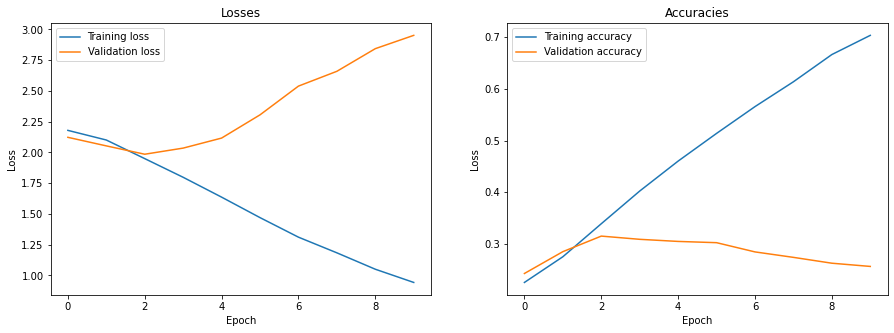

In [19]:
import matplotlib.pyplot as plt

# Graficar accuracy y loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(tr_loss, label='Training loss')
ax[0].plot(val_loss, label='Validation loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

### Validar con el conjunto de prueba

In [20]:
# Evaluarv el modelo con el conjunto de prueba (test)
model.load_state_dict(torch.load('GRU_sentiment_analysis_model.pt'))

test_loss, test_acc, y_true, y_pred = testing(model, testloader, loss_function)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.000 | Test Acc: 30.56%


### Visualizar resultados por clase

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print( classification_report(y_true, y_pred, target_names=tag_vocabulary) )

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        13
     boredom       0.00      0.00      0.00        21
       empty       0.00      0.00      0.00        96
  enthusiasm       0.00      0.00      0.00        91
         fun       0.00      0.00      0.00       204
   happiness       0.27      0.19      0.22       601
        hate       0.00      0.00      0.00       156
        love       0.28      0.41      0.34       430
     neutral       0.34      0.45      0.38       980
      relief       0.00      0.00      0.00       178
     sadness       0.48      0.02      0.04       596
    surprise       0.00      0.00      0.00       259
       worry       0.30      0.68      0.41       983

    accuracy                           0.30      4608
   macro avg       0.13      0.13      0.11      4608
weighted avg       0.26      0.30      0.23      4608



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
